In [1]:
!pip install -q pyswarms cma

# Imports

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import minimize, dual_annealing
from pyswarms.single.global_best import GlobalBestPSO
from cma import CMAEvolutionStrategy

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Helper Functions

In [3]:
def set_model_weights_from_vector(model, weight_vector):
    """Set the weights of the model from a numpy vector."""
    weight_tensor = torch.tensor(weight_vector, dtype=torch.float64)
    index = 0
    for param in model.parameters():
        param_shape = param.shape
        param_numel = param.numel()
        param.data = weight_tensor[index:index + param_numel].view(param_shape)
        index += param_numel
    return model

def get_vector_from_model_weights(model):
    """Get the weights of the model as a numpy vector."""
    return torch.cat([param.data.view(-1) for param in model.parameters()]).detach().numpy()

In [4]:
def update_tracker(loss_tracker, optimizer_name, loss_value):
    """Update the loss tracker with the latest loss value."""
    loss_tracker[optimizer_name].append(loss_value)

def objective(weight_vector, model, input_tensor, target_tensor):
    """Objective function for optimization algorithms."""
    set_model_weights_from_vector(model, weight_vector)
    output = model(input_tensor)
    loss_value = F.mse_loss(output, target_tensor).item()
    return loss_value

In [5]:
def create_model():
    """Create and return the neural network model."""
    model = nn.Sequential(
        nn.Linear(2, 2, bias=False),
        nn.ReLU(),
        nn.Linear(2, 2, bias=True)
    ).double()
    return model

def prepare_data():
    """Prepare and return the input and target tensors."""
    input_tensor = torch.randn(32, 2).double()
    # Normalize input data to avoid scaling issues
    input_tensor = (input_tensor - input_tensor.mean(dim=0)) / input_tensor.std(dim=0)
    target_tensor = input_tensor.clone()  # Target is the input itself (identity function)
    return input_tensor, target_tensor

In [6]:
# Prepare data and model
input_tensor, target_tensor = prepare_data()
model_template = create_model()
num_parameters = sum(p.numel() for p in model_template.parameters())
max_iterations = 50
initial_weights = 0.1 * np.random.randn(num_parameters)
loss_tracker = defaultdict(list)

# Optimizer Methods

In [7]:
def run_pytorch_adam_optimizer(initial_weights, model, input_tensor, target_tensor, max_iterations, loss_tracker, optimizer_name="PyTorch Adam"):
    """Run PyTorch's Adam optimizer on the model."""
    set_model_weights_from_vector(model, initial_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    for iteration in range(max_iterations):
        optimizer.zero_grad()
        output = model(input_tensor)
        loss = F.mse_loss(output, target_tensor)
        loss.backward()
        optimizer.step()
        update_tracker(loss_tracker, optimizer_name, loss.item())
    final_weights = get_vector_from_model_weights(model)
    return final_weights, loss.item()

In [8]:
# Run PyTorch Adam optimizer
optimizer_name = "PyTorch Adam"
model = create_model()
final_weights, final_loss = run_pytorch_adam_optimizer(
    initial_weights, model, input_tensor, target_tensor, max_iterations, loss_tracker, optimizer_name
)
print(f"Final loss {optimizer_name}: {final_loss}")

Final loss PyTorch Adam: 0.2109956807454797


In [9]:
def run_scipy_slsqp_optimizer(initial_weights, model, input_tensor, target_tensor, max_iterations, loss_tracker, optimizer_name="SLSQP"):
    """Run SciPy's SLSQP optimizer on the model."""
    class SciPyOptimizerHelper:
        def __init__(self, model, input_tensor, target_tensor):
            self.model = model
            self.input_tensor = input_tensor
            self.target_tensor = target_tensor
            self.iteration = 0

        def objective(self, weight_vector):
            return objective(weight_vector, self.model, self.input_tensor, self.target_tensor)

        def callback(self, xk):
            loss_value = self.objective(xk)
            update_tracker(loss_tracker, optimizer_name, loss_value)
            self.iteration += 1

    helper = SciPyOptimizerHelper(model, input_tensor, target_tensor)
    result = minimize(
        helper.objective,
        initial_weights,
        method='SLSQP',
        callback=helper.callback,
        options={"maxiter": max_iterations, "disp": False, "eps": 1e-8}
    )
    final_weights = result.x
    final_loss = result.fun
    return final_weights, final_loss

In [10]:
# Run SciPy SLSQP optimizer
optimizer_name = "SLSQP"
model = create_model()
final_weights, final_loss = run_scipy_slsqp_optimizer(
    initial_weights, model, input_tensor, target_tensor, max_iterations, loss_tracker, optimizer_name
)
print(f"Final loss {optimizer_name}: {final_loss}")

Final loss SLSQP: 0.24376125883444166


In [11]:
def run_pyswarms_pso_optimizer(initial_weights, model, input_tensor, target_tensor, max_iterations, loss_tracker, optimizer_name="PSO"):
    """Run Particle Swarm Optimization using pyswarms on the model."""
    num_dimensions = len(initial_weights)
    bounds = (-5 * np.ones(num_dimensions), 5 * np.ones(num_dimensions))

    def objective_wrapper(weights):
        losses = []
        for weight_vector in weights:
            loss_value = objective(weight_vector, model, input_tensor, target_tensor)
            losses.append(loss_value)
        return np.array(losses)

    optimizer = GlobalBestPSO(n_particles=50, dimensions=num_dimensions, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=bounds)
    cost, pos = optimizer.optimize(objective_wrapper, iters=max_iterations, verbose=False)

    # Update loss tracker
    for loss in optimizer.cost_history:
        update_tracker(loss_tracker, optimizer_name, loss)

    final_weights = pos
    final_loss = cost
    return final_weights, final_loss

In [12]:
# Run PySwarms Particle Swarm Optimization
optimizer_name = "PSO"
model = create_model()
final_weights, final_loss = run_pyswarms_pso_optimizer(
    initial_weights, model, input_tensor, target_tensor, max_iterations, loss_tracker, optimizer_name
)
print(f"Final loss {optimizer_name}: {final_loss}")

Final loss PSO: 0.33896100122662076


In [13]:
def run_cma_es_optimizer(initial_weights, model, input_tensor, target_tensor, max_iterations, loss_tracker, optimizer_name="CMA-ES"):
    """Run CMA Evolution Strategy optimizer on the model."""
    es = CMAEvolutionStrategy(initial_weights, 0.5, {'maxiter': max_iterations, 'seed': 42})
    while not es.stop():
        solutions = es.ask()
        fitnesses = [objective(x, model, input_tensor, target_tensor) for x in solutions]
        es.tell(solutions, fitnesses)
        best_fitness = es.result.fbest
        update_tracker(loss_tracker, optimizer_name, best_fitness)
    final_weights = es.result.xbest
    final_loss = es.result.fbest
    return final_weights, final_loss

In [14]:
# Run CMA Evolution Strategy optimizer
optimizer_name = "CMA-ES"
model = create_model()
final_weights, final_loss = run_cma_es_optimizer(
    initial_weights, model, input_tensor, target_tensor, max_iterations, loss_tracker, optimizer_name
)
print(f"Final loss {optimizer_name}: {final_loss}")

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=42, Sat Oct 19 19:58:19 2024)
Final loss CMA-ES: 0.24615146797612414


In [15]:
def run_dual_annealing_optimizer(initial_weights, model, input_tensor, target_tensor, max_iterations, loss_tracker, optimizer_name="Simulated Annealing"):
    """Run Dual Annealing optimizer on the model."""
    bounds = [(-5, 5)] * len(initial_weights)
    args = (model, input_tensor, target_tensor)
    iteration = 0

    def callback(x, f, context):
        nonlocal iteration
        if iteration >= max_iterations:
            return True
        update_tracker(loss_tracker, optimizer_name, f)
        iteration += 1

    result = dual_annealing(
        objective,
        bounds,
        args=args,
        maxiter=max_iterations,
        initial_temp=5230.0,
        no_local_search=True,
        callback=callback
    )
    final_weights = result.x
    final_loss = result.fun
    return final_weights, final_loss

In [16]:
# Run Dual Annealing optimizer
optimizer_name = "Simulated Annealing"
model = create_model()
final_weights, final_loss = run_dual_annealing_optimizer(
    initial_weights, model, input_tensor, target_tensor, max_iterations, loss_tracker, optimizer_name
)
print(f"Final loss {optimizer_name}: {final_loss}")

Final loss Simulated Annealing: 0.2895449462050786


# Plotting Losses

In [17]:
def plot_losses(loss_tracker):
    """Plot the loss curves for different optimizers."""
    plt.figure(figsize=(12, 7))
    line_styles = ['-', '--', '-.', ':', '-']
    for i, (optimizer_name, losses) in enumerate(loss_tracker.items()):
        plt.plot(
            losses,
            label=optimizer_name,
            linestyle=line_styles[i % len(line_styles)],
            linewidth=2,
        )
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.yscale('log')
    plt.title("Loss for Different Optimizers", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

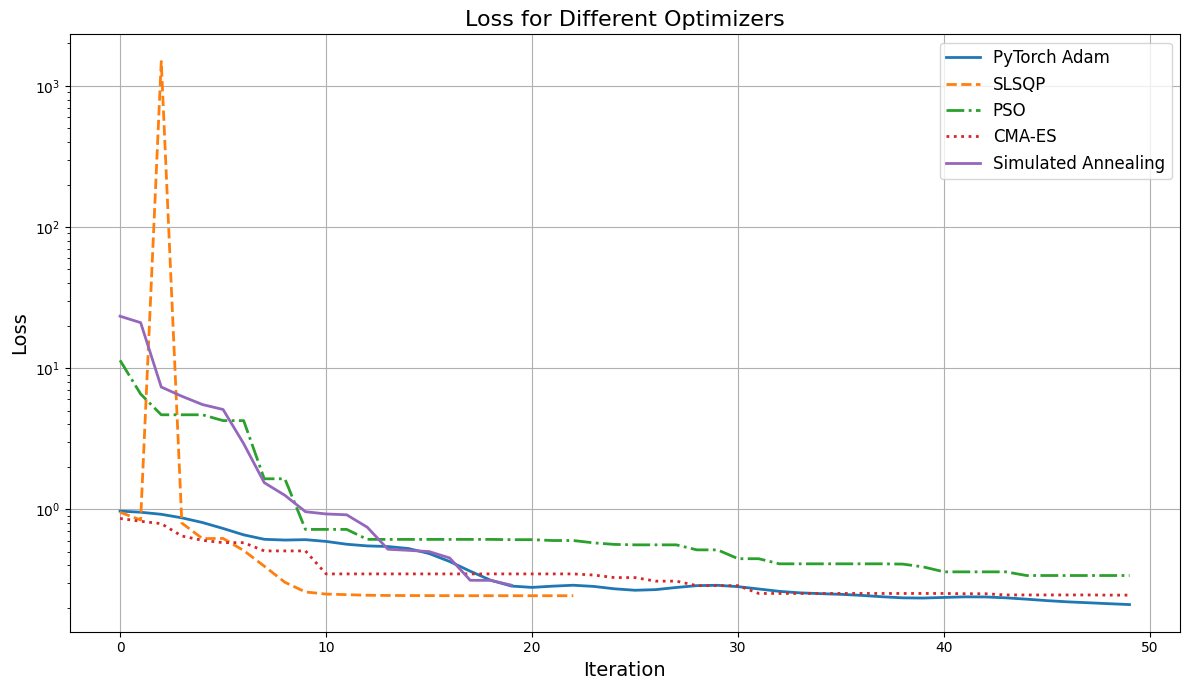

In [18]:
# Plot the loss curves
plot_losses(loss_tracker)